In [1]:
import os
import sys
import time
import copy

from LossJLearn.base import TFBaseEstimator
from LossJLearn.datasets import load_linear_data, load_data_from_func
from LossJLearn.utils.plot import (show_linear_point, 
                                   show_regressor_linear, 
                                   show_regressor_linear_sgd, 
                                   show_regression_line, 
                                   show_regressor_loss)
from LossJLearn.preprocessing import NumpyMinMaxScaler

import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
%matplotlib inline


print("python version: ", sys.version_info)
print(tf.__name__, tf.__version__)
print(keras.__name__, keras.__version__)

python version:  sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
tensorflow 2.3.0
tensorflow.keras 2.4.0


## 1. TensorFlow2 实现Linear Regression

### 1.1 TFRegressorMixin

In [2]:
class TFRegressorMixin:
    """Regressor Mixin with tensorflow. Mainly realized the score method."""

    def score(self, X_test, y_test):
        """Use test dataset to evaluate the trained model.

        Args:
            X_test: A tf.Tensor matrix of (n_samples, n_features) shape.
            y_test: A tf.Tensor array of (n_samples, ) shape. data type must be
                discrete value.
        Returns:
            return R^2, a np.ndarray float number. R^2 = 1 - u / v.
                u = sum((y_pred - y_true)^2), v = sum((y_true - y_true_mean)^2)
        """
        X_test, y_test = self._score_validation(X_test, y_test)
        y_pred = self.predict(X_test, _miss_valid=True)
        y_true_mean = tf.reduce_mean(y_test, axis=0)
        u = tf.reduce_sum(tf.square(y_pred - y_test))
        v = tf.reduce_sum(tf.square(y_test - y_true_mean))
        r_squared = 1 - u / v
        return r_squared.numpy()

### 1.2 TFBaseLinearRegressor

In [3]:
class TFBaseLinearRegressor(TFBaseEstimator, TFRegressorMixin):
    """Linear regressor base class with tensorflow, explicitly inherits 
        from TFBaseEstimator and TFRegressorMixin already.
    
    Attributes:
        _X_train:feature data for training. A tf.Tensor matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train:label data for training. A tf.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A tf.Tensor matrix of (n_features, 1) shape.
        intercept_: intercept of regressor. A tf.Tensor integer if intercept_ is not None else None.
    """

    def __init__(self, fit_intercept=True, random_state=None):
        """linear regressor init method.
        
        Args:
            fit_intercept: Bool value. If use intercept in the linear regressor model.
        """
        self._X_train = None
        self._y_train = None
        self.coef_ = None
        if random_state:
            assert isinstance(random_state, int)
            tf.random.set_seed = random_state
        self.intercept_ = tf.random.normal(shape=[]) if fit_intercept else None

    def fit(self, X_train, y_train):
        """method for training model. 
        
        Args:
            X_train: A tf.Tensor matrix of (n_samples, n_features) shape, data type must be continuous value type. 
            y_train: A tf.Tensor array of (n_samples, ) shape.
        
        Returns:
            self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        if self.intercept_:
            self._X_train = tf.concat(
                [self._X_train, tf.ones([self._X_train.shape[0], 1])], axis=1
            )
        self._calculate_coef()
        if self.intercept_:
            self.intercept_ = self.coef_[-1][0]
            self._X_train = self._X_train[:, :-1]
            self.coef_ = self.coef_[:-1]
        return self

    def predict(self, X_test, _miss_valid=False):
        """predict test data.
        
        Args:
            X_test: A tf.Tensor matrix of (n_samples, n_features) shape, 
                or a tf.Tensor array of (n_features, ) shape.
        
        Returns:
            result of predict. A tf.Tensor array of (n_samples, ) shape.
        """
        if not _miss_valid:
            X_test = self._predict_validation(X_test)
        product = X_test @ self.coef_
        result =  product if self.intercept_ is None else product + self.intercept_
        return tf.reshape(result, [-1])

### 1.3 TFLinearRegressor

In [4]:
class TFLinearRegressor(TFBaseLinearRegressor):
    """Linear regressor class with tensorflow, explicitly inherits from TFBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A tf.Tensor matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train:label data for training. A tf.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A tf.Tensor matrix of (n_features, 1) shape.
        intercept_: intercept of regressor. A tf.Tensor integer if intercept_ is not None else None.
    """

    def _calculate_coef(self):
        xtx = tf.transpose(self._X_train) @ self._X_train
        try:
            xtx_inv = tf.linalg.inv(xtx)
        except tf.errors.InvalidArgumentError as ex:
            raise ex
        self.coef_ = (
            tf.linalg.inv(xtx) \
            @ tf.transpose(self._X_train) \
            @ tf.reshape(self._y_train, [-1, 1])
        )

In [5]:
x, y = load_linear_data(1000)
x.shape, y.shape

((1000, 1), (1000,))

In [6]:
rgs = TFLinearRegressor()
rgs.fit(x, y)

In [7]:
rgs.coef_, rgs.intercept_

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5474339]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.2160227>)

In [8]:
rgs = TFLinearRegressor(fit_intercept=False)
rgs.fit(x, y)
rgs.coef_, rgs.intercept_

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.73182887]], dtype=float32)>,
 None)

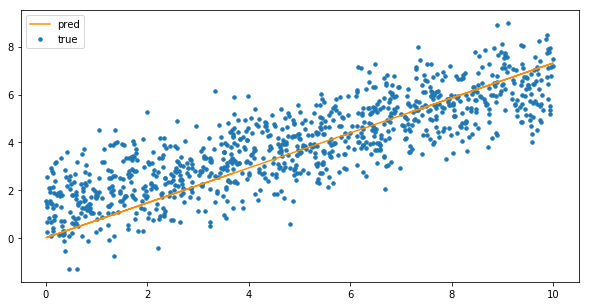

In [9]:
show_regressor_linear(x, y, rgs.coef_, rgs.intercept_)

In [10]:
rgs.score(x, y)

0.5907905

### 1.4 Ridge

In [11]:
class TFRidge(TFBaseLinearRegressor):
    """Ridge regressor class with tensorflow, explicitly inherits from TFBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A tf.Tensor matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train:label data for training. A tf.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A tf.Tensor matrix of (n_features, 1) shape.
        intercept_: intercept of regressor. A tf.Tensor integer if intercept_ is not None else None.
        alpha: the regularize rate. A positive float number, default = 1.0.
    """

    def __init__(self, fit_intercept=True, alpha=1.0, random_state=None):
        """ridge object init method.
        
        Args:
            fit_intercept: Bool value. If use intercept in the ridge model.
            alpha: the regularize rate. A positive float number, default = 1.0.
        
        Raises:
            AssertionError: Alpha value must be a number.
            ValueError: Alpha value must be greater than 0.
        """
        super().__init__(fit_intercept=fit_intercept, random_state=random_state)
        assert isinstance(alpha, int) or isinstance(alpha, float)
        if 0 < alpha:
            self.alpha = alpha
        else:
            raise ValueError("Alpha value must be greater than 0! ")

    def _calculate_coef(self):
        xtx = tf.transpose(self._X_train) @ self._X_train
        self.coef_ = (
            tf.linalg.inv(xtx + self.alpha * tf.eye(self._X_train.shape[1])) \
            @ tf.transpose(self._X_train) \
            @ tf.reshape(self._y_train, [-1, 1])
        )

In [12]:
rgs = TFRidge()
rgs.fit(x, y)
rgs.coef_, rgs.intercept_

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5480834]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.2116275>)

In [13]:
rgs.score(x, y)

0.6972269

## 2. TensorFlow2 实现 SGD Regression

### 2.1 TFSGDRegressor

#### 2.1.1 tf.GradientTape

In [14]:
x = tf.constant(3.0)
w = tf.Variable(0., dtype=tf.float32)
func = lambda x: w * x
with tf.GradientTape() as tape:
    y_pred = func(x)
w_grad = tape.gradient(y_pred, w)
print(f"w_grad: {w_grad}")

w_grad: 3.0


#### 2.1.2 keras.optimizers.SGD

In [15]:
x = tf.constant(3.0)
w = tf.Variable(0., dtype=tf.float32)
y = tf.constant(6.2)
func = lambda x: w * x
optimizer = keras.optimizers.SGD(learning_rate=0.001)
with tf.GradientTape() as tape:
    y_pred = func(x)
    loss = tf.square(y_pred - y)
w_grad = tape.gradient(loss, w)
print(f"w_grad: {w_grad}")
optimizer.apply_gradients([(w_grad, w)])
print(f"w: {w}")

w_grad: -37.19999694824219
w: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0372>


#### 2.1.3 keras.metrics.MeanSquaredError

In [16]:
metric = keras.metrics.MeanSquaredError()
y_batch1 = tf.constant([1, 2, 3])
y_pred1 = tf.constant([2, 3, 4])
metric(y_batch1, y_pred1)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [17]:
y_batch2 = tf.constant([1, 2, 3])
y_pred2 = tf.constant([1, 2, 3])
metric(y_batch2, y_pred2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [18]:
metric.reset_states()
y_batch3 = tf.constant([1, 2, 3])
y_pred3 = tf.constant([1, 2, 3])
metric(y_batch3, y_pred3)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### 2.1.4 keras.losses.mean_squared_error

In [19]:
y_batch3 = tf.constant([1, 2, 3])
y_pred3 = tf.constant([1, 2, 3])
keras.losses.mean_squared_error(y_batch3, y_pred3)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [20]:
loss_obj = keras.losses.MeanSquaredError()
loss_obj(y_batch3, y_pred3)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [21]:
loss_func = keras.losses.mean_squared_error
loss_func(y_batch3, y_pred3)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

#### 2.1.5 keras.regularizers.l2

In [22]:
w = tf.Variable([1., 2.])
w

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>

In [23]:
regularizer = keras.regularizers.l2(l2=0.01)
regularizer(w)

<tf.Tensor: shape=(), dtype=float32, numpy=0.049999997>

#### 2.1.6 tf.data.Dataset

In [24]:
X_train = tf.random.normal(shape=(20, 3))
y_train = tf.random.normal(shape=(20,))
dataset = tf.data.Dataset.from_tensor_slices(tensors=(X_train, y_train))
dataset

<TensorSliceDataset shapes: ((3,), ()), types: (tf.float32, tf.float32)>

In [25]:
for batch in dataset:
    print(batch)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.36379594, -0.85024196,  0.3736869 ], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-1.66476>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.31060037, -1.1018041 , -1.2058792 ], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4793832>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.9978475, -1.3090036, -0.6165344], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.50190336>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.29238284,  0.1890119 ,  0.6392729 ], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.93503606>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.29604545, -0.45136905,  0.40565118], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-1.2151061>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.43215302,  0.8462821 , -1.1820633 ], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.6158311>)
(<tf.Ten

In [26]:
for data in dataset:
    X_data, y_data = data
    print(X_data.numpy(), y_data.numpy())

[-0.36379594 -0.85024196  0.3736869 ] -1.66476
[ 0.31060037 -1.1018041  -1.2058792 ] 2.4793832
[-0.9978475 -1.3090036 -0.6165344] -0.50190336
[-0.29238284  0.1890119   0.6392729 ] -0.93503606
[ 0.29604545 -0.45136905  0.40565118] -1.2151061
[-0.43215302  0.8462821  -1.1820633 ] -0.6158311
[-0.8943976 -1.858387  -0.4793637] -0.83810246
[-0.2642775  -0.06083797 -1.3767616 ] 1.3416129
[-0.9442899  -0.8060043  -0.12252891] -0.045488946
[-0.49674124  0.6785742  -1.6981386 ] -1.0073096
[ 0.69391286 -0.4794601  -1.014987  ] -1.5988295
[-0.53535944  0.04942963  0.03827051] 2.2098377
[ 0.01708315  0.7542125  -0.0212695 ] -0.51724416
[-0.5732798  -0.31354272  1.5602759 ] -0.77388954
[ 1.6356715  -0.37367663 -0.17905644] -1.7105348
[-0.9061674   1.0755994  -0.10889751] 0.97790366
[-0.19706133  2.0348182   0.383922  ] 0.06201346
[ 1.6921422  -0.32945243  0.5748744 ] -0.3213062
[-1.2886639 -1.4894724 -0.8645768] 0.19417682
[-0.03075081 -2.7083917   0.13387075] 1.7064724


In [27]:
dataset.shuffle(buffer_size=X_train.shape[0])

<ShuffleDataset shapes: ((3,), ()), types: (tf.float32, tf.float32)>

In [28]:
dataset = dataset.shuffle(buffer_size=X_train.shape[0])
for data in dataset:
    X_data, y_data = data
    print(X_data.numpy(), y_data.numpy())

[-0.9061674   1.0755994  -0.10889751] 0.97790366
[ 1.6921422  -0.32945243  0.5748744 ] -0.3213062
[-0.53535944  0.04942963  0.03827051] 2.2098377
[-0.49674124  0.6785742  -1.6981386 ] -1.0073096
[-0.36379594 -0.85024196  0.3736869 ] -1.66476
[ 0.69391286 -0.4794601  -1.014987  ] -1.5988295
[ 0.01708315  0.7542125  -0.0212695 ] -0.51724416
[-0.8943976 -1.858387  -0.4793637] -0.83810246
[ 1.6356715  -0.37367663 -0.17905644] -1.7105348
[-0.29238284  0.1890119   0.6392729 ] -0.93503606
[-0.2642775  -0.06083797 -1.3767616 ] 1.3416129
[-0.5732798  -0.31354272  1.5602759 ] -0.77388954
[-0.43215302  0.8462821  -1.1820633 ] -0.6158311
[-0.03075081 -2.7083917   0.13387075] 1.7064724
[-0.9442899  -0.8060043  -0.12252891] -0.045488946
[ 0.31060037 -1.1018041  -1.2058792 ] 2.4793832
[ 0.29604545 -0.45136905  0.40565118] -1.2151061
[-1.2886639 -1.4894724 -0.8645768] 0.19417682
[-0.19706133  2.0348182   0.383922  ] 0.06201346
[-0.9978475 -1.3090036 -0.6165344] -0.50190336


In [29]:
batch_size = 5
dataset = dataset.batch(batch_size)
dataset

<BatchDataset shapes: ((None, 3), (None,)), types: (tf.float32, tf.float32)>

In [30]:
for batch in dataset:
    X_batch, y_batch = batch
    print(X_batch, y_batch)
    break

tf.Tensor(
[[-0.49674124  0.6785742  -1.6981386 ]
 [-0.9978475  -1.3090036  -0.6165344 ]
 [-0.53535944  0.04942963  0.03827051]
 [-0.5732798  -0.31354272  1.5602759 ]
 [-0.29238284  0.1890119   0.6392729 ]], shape=(5, 3), dtype=float32) tf.Tensor([-1.0073096  -0.50190336  2.2098377  -0.77388954 -0.93503606], shape=(5,), dtype=float32)


#### TFSGDRegressor

In [31]:
def sec2time(sec):
    assert isinstance(sec, (int, float))
    if sec >= 60:
        minute = int(sec % 600 // 60)
        sec = int(sec % 60)
        if sec >= 600:
            hour = int(sec // 600)
            return f"{hour}:{minute}:{sec}"
        else:
            return f"{minute}:{sec}"
    else:
        if sec > 1:
            return f"{int(sec)}s"
        elif sec > 0.001:
            return f"{int(sec * 1000)}ms"
        elif sec > 0.000001:
            return f"{int(sec * 1000 * 1000)}us"
        else:
            return "0s"

In [32]:
class TFSGDRegressor(TFBaseLinearRegressor):
    """Linear SGD regressor class with tensorflow, explicitly inherits 
        from TFBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A tf.Tensor matrix of (n_samples,
            n_features) shape, data type must be continuous value type. 
        _y_train:label data for training. A tf.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A tf.Tensor matrix of (n_features, 1) shape.
        intercept_: intercept of regressor. A tf.Tensor integer if intercept_ is 
            not None else None.
        alpha: the regularize rate. A float number and must be greater than 0, 
            default = 0.001.
        save_param_list: if save param of the train process. A bool value, default = True.
        coef_list: list of coef param from the train process,
            every coef is a np.ndarray of (n_features, ) shape.
        intercept_list: list of intercept param from the train process, 
            every intercept is a np.ndarray float number.
        learning_rate: learning rate. A positive float number, default = 0.001.
        epochs: epochs. A positive int number, default = 10.
        batch_size: batch size. A positive int number, default = 32.
        early_stopping: if early stopping when loss don't reduce again. A bool value,
            default = True.
        patient: Number of epochs that do not reduce loss continuously, 
            patient only takes effect when early_stopping is True. 
            A positive int number, default = 5.
        toc: The threshold that symbolizes loss no longer decreases, 
            toc only takes effect when early_stopping is True. 
            A float number, default = 0.001
        random_state: random seed. A positive int number if random_state 
            is not None else None, default = None.
        regularize: regularize. A str value in {"l1", "l2"} if regularize 
            is not None else None, default = None.
        best_loss: best loss of the train process. A np.ndarray float number.
        best_coef: best coef of the train process. A tf.Tensor array of 
            (n_features, 1) shape.
        best_intercept_: best intercept of the train process. A tf.Tensor number.
        train_loss: list of train loss from the train process. 
            every loss is a np.ndarray float number.
        valid_loss: list of valid loss from the train process.
            every loss is a np.ndarray float number.
        n_iter: the actual iteration of train process. A int number, initial = 0.
        save_best_model: if save the best model params as the final model.
                A bool value, defalut = True.
    """
    
    def __init__(
        self,
        loss="mse",
        alpha=0.001,
        fit_intercept=True,
        save_param_list=True,
        learning_rate=0.001,
        epochs=10,
        batch_size=32,
        early_stopping=True,
        patient=5,
        toc=0.001,
        random_state=None,
        regularize=None,
        save_best_model=True
    ):
        """TFSGDRegressor initial method.
        
        Args:
            loss: A str in {"mse"}, default = "mse"
            alpha: the regularize rate. A float number and must be greater
                than 0, default = 0.001.
            fit_intercept: if fit intercept. A bool value, default = True. 
            save_param_list: if save param of the train process. A bool value,
                default = True.
            learning_rate: learning rate. A positive float number, default = 0.001.
            epochs: epochs. A positive int number, default = 10.
            batch_size: batch size. A positive int number, default = 32.
            early_stopping: if early stopping when loss don't reduce again. 
                A bool value, default = True
            patient: Number of epochs that do not reduce loss continuously, 
                patient only takes effect when early_stopping is True. 
                A positive int number, default = 5.
            toc: The threshold that symbolizes loss no longer decreases, 
                toc only takes effect when early_stopping is True. 
                A float number, default = 0.001
            random_state: random seed. A positive int number if random_state 
                is not None else None, default = None.
            regularize: regularize. A str value in {"l1", "l2"} if regularize 
                is not None else None, default = None.
            save_best_model: if save the best model params as the final model.
                A bool value, defalut = True
        
        Raises:
            AssertionError: Some parameters do not match.
        """
        (
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            save_best_model
        ) = self._init_validation(
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            save_best_model
        )
        self.random_state = random_state
        if isinstance(self.random_state, int):
            tf.random.set_seed(self.random_state)
            
        loss_func_dict = {"mse": keras.losses.mean_squared_error}
        self._loss_func = loss_func_dict[loss]
        metric_dict = {"mse": keras.metrics.MeanSquaredError}
        self._metric = metric_dict[loss]()
        
        self.alpha = alpha
        
        self.intercept_ = None
        if fit_intercept:
            self.intercept_ = tf.Variable(tf.random.normal([]))
        
        self.save_param_list = save_param_list
        self.coef_list = []
        self.intercept_list = []
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patient = patient
        self.toc = toc
        
        self.regularize = regularize
        self._regularizer = lambda: 0
        if self.regularize:
            reg_dict = {"l1": keras.regularizers.l1(l1=self.alpha), "l2": keras.regularizers.l2(l2=self.alpha)}
            self._regularizer = reg_dict[self.regularize]
            
        self.save_best_model = save_best_model
        
        self._X_train = None
        self._y_train = None
        
        self.coef_ = None

        self._optimizer = keras.optimizers.SGD(learning_rate=self.learning_rate)
        
        self.best_loss = tf.constant(float("inf")).numpy()
        self.best_coef_ = None
        self.best_intercept_ = None
        self.train_loss = []
        self.valid_loss = []
        
        self.n_iter = 0

    def fit(self, X_train, y_train, validation=None):
        """train model methed.
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape, data type 
                must be continuous value type.
            validation: the validation data for validate the model. A tuple
                like (X_valid, y_valid) , the shape of X_valid and y_valid is 
                like X_train and y_train. Default = None.
        
        Returns:
            return self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        X_train, y_train = self._X_train, self._y_train
        if self.coef_ is None:
            self.coef_ = tf.Variable(tf.random.normal(shape=[self._X_train.shape[1], 1]))
        X_valid, y_valid, X_train, y_train = self._validation_valid(validation, X_train, y_train)
        steps_per_epoch = self._X_train.shape[0] // self.batch_size
        if self.early_stopping:
            current_patient = 0 
            last_val_loss = 0
        for epoch in range(self.epochs):
            # 1. train
            train_data = self._batch_generator(X_train, y_train)
            epoch_time = 0
            print(f"Epoch {epoch + 1}/{self.epochs}")
            self._metric.reset_states()
            for step, (X_train_batch, y_train_batch) in enumerate(train_data):
                start = time.time()
                self._fit_step(X_train_batch, y_train_batch)
                epoch_time, mean_step_time, train_loss = self._step_print(steps_per_epoch, step, epoch_time, start)
            
            # 2. valid
            val_loss = self._epoch_valid_and_print(X_valid, y_valid, epoch_time, mean_step_time, steps_per_epoch)
            
            # 3. save train process
            self._save_train_process(val_loss, train_loss)
            
            self.n_iter += 1
            
            # 4. early stopping
            if self.early_stopping:
                if epoch != 0:
                    if last_val_loss - val_loss < self.toc:
                        current_patient += 1
                    else:
                        current_patient = 0
                    if current_patient >= self.patient:
                        break
                last_val_loss = val_loss
        
        if self.save_best_model:
            self._save_best_params()
        return self
    
    def _save_best_params(self):
        self.coef_ = copy.deepcopy(self.best_coef_)
        if self.intercept_ is not None:
            self.intercept_ = copy.deepcopy(self.best_intercept_)
    
    def _save_train_process(self, val_loss, train_loss):
        if val_loss < self.best_loss:
            self.best_loss = copy.deepcopy(val_loss)
            self.best_coef_ = copy.deepcopy(self.coef_)
            if self.intercept_ is not None:
                self.best_intercept_ = copy.deepcopy(self.intercept_)
        if self.save_param_list:
            self.coef_list.append(self.coef_.numpy().reshape([-1]))
            if self.intercept_ is not None:
                self.intercept_list.append(self.intercept_.numpy())
            self.train_loss.append(train_loss)
            self.valid_loss.append(val_loss)
    
    def _validation_valid(self, validation, X_train, y_train):
        if validation is None:
            n_samples = int(self._X_train.shape[0] * 0.8)
            idx = tf.random.shuffle(tf.range(self._X_train.shape[0]))
            X_train = tf.gather(self._X_train, indices=idx[:n_samples])
            y_train = tf.gather(self._y_train, indices=idx[:n_samples])
            X_valid = tf.gather(self._X_train, indices=idx[n_samples:])
            y_valid = tf.gather(self._y_train, indices=idx[n_samples:])
        else:
            X_valid, y_valid = self._fit_validation(*validation)
        return X_valid, y_valid, X_train, y_train

    @tf.function
    def _call(self, X):
        y = tf.matmul(X, self.coef_)
        if self.intercept_ is not None:
            y = tf.add(y, self.intercept_)
        return tf.reshape(y, shape=[-1])

    def _batch_generator(self, X, y, shuffle=True):
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=self._X_train.shape[0])
        dataset = dataset.batch(self.batch_size)
        return dataset

    def _init_validation(
        self,
        loss,
        alpha,
        fit_intercept,
        save_param_list,
        learning_rate,
        epochs,
        batch_size,
        early_stopping,
        patient,
        toc,
        random_state,
        regularize,
        save_best_model,
    ):
        assert loss in {"mse"}
        assert isinstance(alpha, (int, float)) and 0 < alpha
        assert isinstance(fit_intercept, bool)
        assert isinstance(save_param_list, bool)
        assert isinstance(learning_rate, (int, float)) and 0 < learning_rate <= 1.0
        assert isinstance(epochs, int) and epochs >= 1
        assert isinstance(batch_size, int) and batch_size >= 1
        assert isinstance(early_stopping, bool)
        assert isinstance(patient, int) and patient >= 2
        assert isinstance(toc, (int, float)) and 0 < toc
        assert isinstance(random_state, (type(None), int))
        if isinstance(random_state, int):
            assert random_state >= 0
        assert regularize in {"l2", "l1", None}
        assert isinstance(save_best_model, bool)
        return (
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            save_best_model
        )
    
    def _fit_step(self, X_train_batch, y_train_batch):
        # 1.open a tape and calculate loss under the tape
        with tf.GradientTape() as tape:
            y_pred_batch = self._call(X_train_batch)
            loss = self._loss_func(y_train_batch, y_pred_batch)
            if self.regularize:
                loss += self._regularizer(self.coef_)
        if self.intercept_ is not None:
            # 2.use tape to calculate gradients by loss
            coef_grad, intercept_grad = tape.gradient(
                loss, [self.coef_, self.intercept_]
            )
            # 3.use optimizer to update params by gradients
            # self.coef_.assign_sub(coef_grad * self.learning_rate)
            # self.intercept_.assign_sub(intercept_grad * self.learning_rate)
            self._optimizer.apply_gradients(
                [(coef_grad, self.coef_), (intercept_grad, self.intercept_)]
            )
        else:
            coef_grad = tape.gradient(loss, self.coef_)
            self._optimizer.apply_gradients([(coef_grad, self.coef_)])
        # 4.use metric to calculate the mean loss for output
        self._metric(y_train_batch, y_pred_batch)
        
    def _step_print(self, steps_per_epoch, step, epoch_time, start):
        steps_str_len = len(str(steps_per_epoch))
        done_count = int((step + 1) / steps_per_epoch * 30)
        done_str = "=" * done_count
        to_do_str = "." * (30 - 1 - done_count)
        end = time.time()
        step_time = end - start
        epoch_time += step_time
        mean_step_time = epoch_time / (step + 1)
        remain_time = (steps_per_epoch - (step + 1)) * mean_step_time
        remain_time = sec2time(remain_time)
        print(
            f"\r{step + 1:{steps_str_len}}/{steps_per_epoch} [{done_str}>{to_do_str}] - ETA: {remain_time} - loss: {self._metric.result().numpy():.4f}",
            end="",
        )
        return epoch_time, mean_step_time, self._metric.result().numpy()
    
    def _epoch_valid_and_print(self, X_valid, y_valid, epoch_time, mean_step_time, steps_per_epoch):
        valid_data = self._batch_generator(X_valid, y_valid, shuffle=False)
        train_mean_loss = self._metric.result().numpy()
        self._metric.reset_states()
        for valid_step, (X_valid_batch, y_valid_batch) in enumerate(valid_data):
            y_valid_pred = self._call(X_valid_batch)
            self._metric(y_valid_batch, y_valid_pred)
        epoch_time = sec2time(epoch_time)
        mean_step_time = sec2time(mean_step_time)
        print(
            f"\r{steps_per_epoch}/{steps_per_epoch} [{'=' * 30}] - {epoch_time} {mean_step_time}/step - loss: {train_mean_loss:.4f} - val_loss: {self._metric.result().numpy():.4f}"
        )
        return self._metric.result().numpy()

In [33]:
x, y = load_linear_data(500, w=0.5493, b=1.1973)

In [34]:
rgs = TFSGDRegressor(learning_rate=0.001, random_state=10383)
rgs.fit(x[:400], y[:400])

Epoch 1/10
12/12 [==============================] - 166ms 16ms/step - loss: 31.7488 - val_loss: 13.0101
Epoch 2/10
12/12 [==============================] - 34ms 3ms/step - loss: 7.9925 - val_loss: 3.9802
Epoch 3/10
12/12 [==============================] - 39ms 3ms/step - loss: 2.7744 - val_loss: 1.8991
Epoch 4/10
12/12 [==============================] - 33ms 3ms/step - loss: 1.6249 - val_loss: 1.3761
Epoch 5/10
12/12 [==============================] - 37ms 3ms/step - loss: 1.3617 - val_loss: 1.2235
Epoch 6/10
12/12 [==============================] - 35ms 3ms/step - loss: 1.2991 - val_loss: 1.1841
Epoch 7/10
12/12 [==============================] - 34ms 3ms/step - loss: 1.2818 - val_loss: 1.1640
Epoch 8/10
12/12 [==============================] - 39ms 3ms/step - loss: 1.2754 - val_loss: 1.1559
Epoch 9/10
12/12 [==============================] - 37ms 3ms/step - loss: 1.2726 - val_loss: 1.1507
Epoch 10/10
12/12 [==============================] - 35ms 3ms/step - loss: 1.2678 - val_loss: 1.

In [35]:
rgs.coef_, rgs.intercept_

(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.70767456]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.072912954>)

In [36]:
rgs.score(x[400:], y[400:])

0.630091

In [37]:
rgs.coef_list[:10], rgs.intercept_list[:10]

([array([0.14807323], dtype=float32),
  array([0.44936165], dtype=float32),
  array([0.58843017], dtype=float32),
  array([0.6538595], dtype=float32),
  array([0.68655646], dtype=float32),
  array([0.6981913], dtype=float32),
  array([0.70491195], dtype=float32),
  array([0.706579], dtype=float32),
  array([0.7067522], dtype=float32),
  array([0.70767456], dtype=float32)],
 [-0.06233093,
  -0.0121039655,
  0.014277775,
  0.029838383,
  0.040578287,
  0.048181944,
  0.05503998,
  0.061134562,
  0.066989325,
  0.072912954])

In [38]:
rgs.valid_loss[:10]

[13.0100565,
 3.9802287,
 1.8991321,
 1.3760743,
 1.2234887,
 1.1840658,
 1.1639893,
 1.155885,
 1.1506972,
 1.1444411]

In [39]:
rgs.best_coef_, rgs.best_intercept_

(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.70767456]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.072912954>)

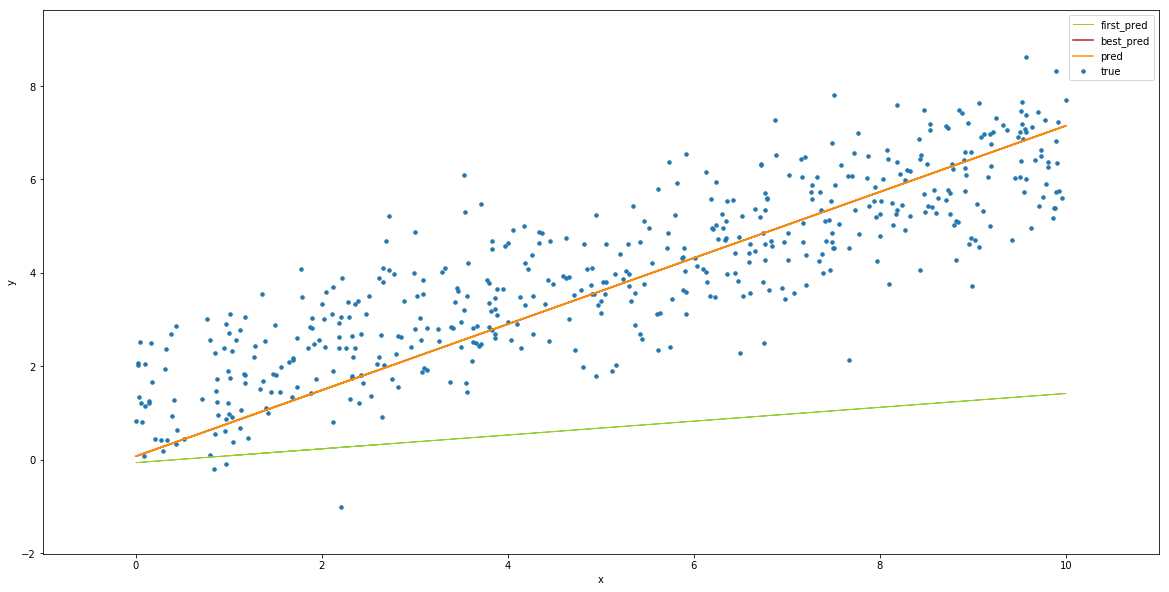

In [40]:
show_regressor_linear_sgd(
    x,
    y,
    rgs.coef_list,
    rgs.best_coef_.numpy().reshape([-1]),
    rgs.intercept_list,
    rgs.best_intercept_.numpy(),
    pause_second=0.001,
    step=1,
    max_iter=10
)

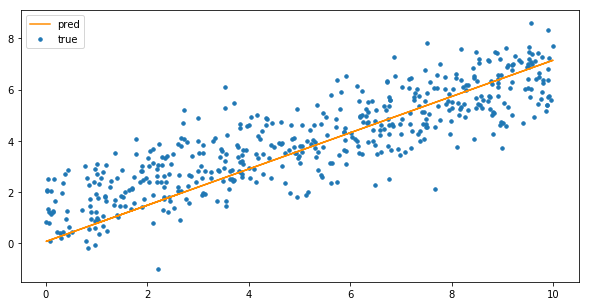

In [41]:
show_regressor_linear(x, y, rgs.coef_, rgs.intercept_)

In [42]:
# l2 regularize
rgs = TFSGDRegressor(regularize="l2")
rgs.fit(x, y)

Epoch 1/10
15/15 [==============================] - 115ms 8ms/step - loss: 23.8297 - val_loss: 7.0376
Epoch 2/10
15/15 [==============================] - 51ms 3ms/step - loss: 4.0120 - val_loss: 1.9484
Epoch 3/10
15/15 [==============================] - 51ms 3ms/step - loss: 1.3976 - val_loss: 1.2603
Epoch 4/10
15/15 [==============================] - 50ms 3ms/step - loss: 1.0398 - val_loss: 1.1566
Epoch 5/10
15/15 [==============================] - 49ms 3ms/step - loss: 1.0064 - val_loss: 1.1442
Epoch 6/10
15/15 [==============================] - 48ms 3ms/step - loss: 0.9819 - val_loss: 1.1422
Epoch 7/10
15/15 [==============================] - 47ms 3ms/step - loss: 0.9668 - val_loss: 1.1409
Epoch 8/10
15/15 [==============================] - 50ms 3ms/step - loss: 0.9948 - val_loss: 1.1397
Epoch 9/10
15/15 [==============================] - 53ms 4ms/step - loss: 0.9933 - val_loss: 1.1391
Epoch 10/10
15/15 [==============================] - 52ms 4ms/step - loss: 0.9709 - val_loss: 1.13

In [43]:
rgs.coef_, rgs.intercept_

(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.6282676]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.623465>)

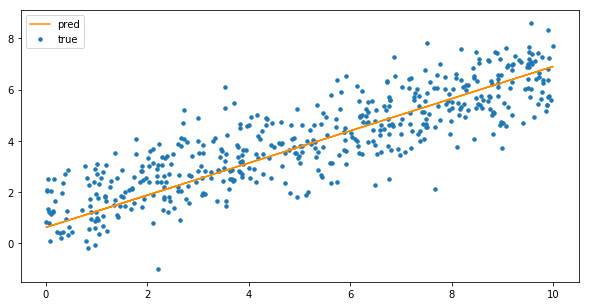

In [44]:
show_regressor_linear(x, y, rgs.coef_, rgs.intercept_)

In [45]:
# valid early stopping
rgs = TFSGDRegressor(learning_rate=0.001, random_state=10383, epochs=10000)
rgs.fit(x[:400], y[:400])

Epoch 1/10000
12/12 [==============================] - 71ms 7ms/step - loss: 31.7488 - val_loss: 13.0101
Epoch 2/10000
12/12 [==============================] - 31ms 3ms/step - loss: 7.9925 - val_loss: 3.9802
Epoch 3/10000
12/12 [==============================] - 35ms 3ms/step - loss: 2.7744 - val_loss: 1.8991
Epoch 4/10000
12/12 [==============================] - 34ms 3ms/step - loss: 1.6249 - val_loss: 1.3761
Epoch 5/10000
12/12 [==============================] - 36ms 3ms/step - loss: 1.3617 - val_loss: 1.2235
Epoch 6/10000
12/12 [==============================] - 36ms 3ms/step - loss: 1.2991 - val_loss: 1.1841
Epoch 7/10000
12/12 [==============================] - 33ms 3ms/step - loss: 1.2818 - val_loss: 1.1640
Epoch 8/10000
12/12 [==============================] - 30ms 3ms/step - loss: 1.2754 - val_loss: 1.1559
Epoch 9/10000
12/12 [==============================] - 31ms 3ms/step - loss: 1.2726 - val_loss: 1.1507
Epoch 10/10000
12/12 [==============================] - 33ms 3ms/step -

In [46]:
rgs.n_iter

178

In [47]:
X_data, y_data = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=10393)

In [48]:
rgs = TFSGDRegressor(learning_rate=0.001, epochs=10)
rgs.fit(X_train, y_train)

Epoch 1/10
11/11 [==============================] - 120ms 12ms/step - loss: inf - val_loss: inf54712064.0000
Epoch 2/10
11/11 [==============================] - 42ms 4ms/step - loss: nan - val_loss: nan
Epoch 3/10
11/11 [==============================] - 44ms 4ms/step - loss: nan - val_loss: nan
Epoch 4/10
11/11 [==============================] - 41ms 4ms/step - loss: nan - val_loss: nan
Epoch 5/10
11/11 [==============================] - 42ms 4ms/step - loss: nan - val_loss: nan
Epoch 6/10
11/11 [==============================] - 38ms 3ms/step - loss: nan - val_loss: nan
Epoch 7/10
11/11 [==============================] - 39ms 3ms/step - loss: nan - val_loss: nan
Epoch 8/10
11/11 [==============================] - 38ms 3ms/step - loss: nan - val_loss: nan
Epoch 9/10
11/11 [==============================] - 38ms 3ms/step - loss: nan - val_loss: nan
Epoch 10/10
11/11 [==============================] - 36ms 3ms/step - loss: nan - val_loss: nan


In [49]:
scaler = NumpyMinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [50]:
# 归一化后
rgs = TFSGDRegressor(learning_rate=0.2, epochs=10, random_state=10382)
rgs.fit(X_train_scaler, y_train)

Epoch 1/10
11/11 [==============================] - 125ms 12ms/step - loss: 137.5302 - val_loss: 55.6120
Epoch 2/10
11/11 [==============================] - 45ms 4ms/step - loss: 58.6631 - val_loss: 46.1243
Epoch 3/10
11/11 [==============================] - 37ms 3ms/step - loss: 44.8885 - val_loss: 42.0271
Epoch 4/10
11/11 [==============================] - 37ms 3ms/step - loss: 41.4892 - val_loss: 46.2876
Epoch 5/10
11/11 [==============================] - 34ms 3ms/step - loss: 39.5966 - val_loss: 35.7099
Epoch 6/10
11/11 [==============================] - 43ms 4ms/step - loss: 40.3813 - val_loss: 48.9018
Epoch 7/10
11/11 [==============================] - 40ms 4ms/step - loss: 39.8612 - val_loss: 33.8038
Epoch 8/10
11/11 [==============================] - 35ms 3ms/step - loss: 33.4643 - val_loss: 33.0794
Epoch 9/10
11/11 [==============================] - 29ms 2ms/step - loss: 36.0855 - val_loss: 32.7658
Epoch 10/10
11/11 [==============================] - 27ms 2ms/step - loss: 32.2

In [51]:
rgs.score(X_test_scaler, y_test)

0.6398372

In [52]:
# 归一化后 + l2正则
rgs = TFSGDRegressor(learning_rate=0.2, epochs=10, random_state=10382, regularize="l2")
rgs.fit(X_train_scaler, y_train)

Epoch 1/10
11/11 [==============================] - 93ms 9ms/step - loss: 137.5632 - val_loss: 55.5582
Epoch 2/10
11/11 [==============================] - 30ms 3ms/step - loss: 58.6987 - val_loss: 46.1044
Epoch 3/10
11/11 [==============================] - 35ms 3ms/step - loss: 44.9296 - val_loss: 42.0207
Epoch 4/10
11/11 [==============================] - 35ms 3ms/step - loss: 41.5326 - val_loss: 46.3386
Epoch 5/10
11/11 [==============================] - 38ms 3ms/step - loss: 39.6951 - val_loss: 35.7306
Epoch 6/10
11/11 [==============================] - 44ms 4ms/step - loss: 40.5040 - val_loss: 48.8611
Epoch 7/10
11/11 [==============================] - 44ms 4ms/step - loss: 39.9702 - val_loss: 33.8847
Epoch 8/10
11/11 [==============================] - 44ms 4ms/step - loss: 33.6091 - val_loss: 33.1446
Epoch 9/10
11/11 [==============================] - 44ms 4ms/step - loss: 36.2926 - val_loss: 32.8881
Epoch 10/10
11/11 [==============================] - 43ms 4ms/step - loss: 32.448

In [53]:
rgs.score(X_test_scaler, y_test)

0.6373894

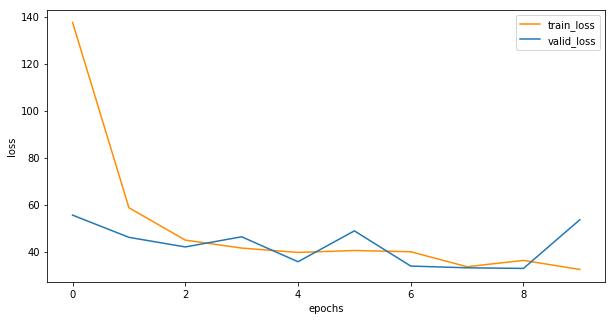

In [54]:
show_regressor_loss(rgs.train_loss, rgs.valid_loss)

### 2.2 tf.keras

In [55]:
model = keras.models.Sequential(keras.layers.Dense(1, input_shape=[1,]))

In [56]:
model.compile(loss="mse", optimizer="sgd")

In [57]:
model.fit(x, y, epochs=10)

Epoch 1/10
16/16 [==============================] - 0s 614us/step - loss: 11.0413
Epoch 2/10
16/16 [==============================] - 0s 616us/step - loss: 1.1410
Epoch 3/10
16/16 [==============================] - 0s 608us/step - loss: 1.0836
Epoch 4/10
16/16 [==============================] - 0s 634us/step - loss: 1.0591
Epoch 5/10
16/16 [==============================] - 0s 628us/step - loss: 1.0632
Epoch 6/10
16/16 [==============================] - 0s 650us/step - loss: 1.0133
Epoch 7/10
16/16 [==============================] - 0s 656us/step - loss: 1.0212
Epoch 8/10
16/16 [==============================] - 0s 638us/step - loss: 1.0050
Epoch 9/10
16/16 [==============================] - 0s 611us/step - loss: 0.9942
Epoch 10/10
16/16 [==============================] - 0s 674us/step - loss: 0.9733


In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.5740624]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.79904777], dtype=float32)>]

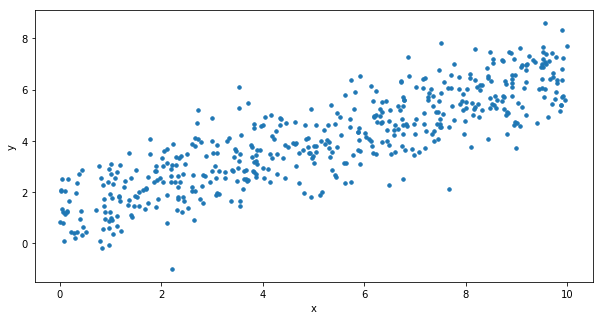

In [60]:
show_linear_point(x, y)

In [61]:
weights = model.layers[0].weights
pred_coef = weights[0].numpy()[0]
pred_intercept = weights[1].numpy()[0]

In [62]:
pred_coef, pred_intercept

(array([0.5740624], dtype=float32), 0.79904777)

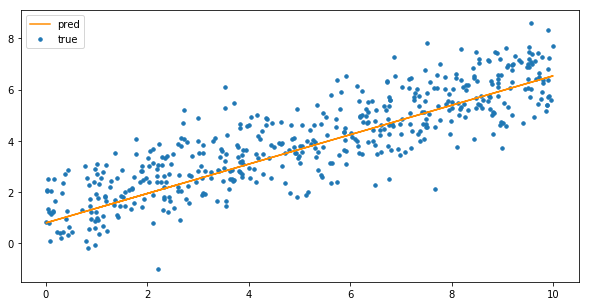

In [63]:
show_regressor_linear(x, y, pred_coef, pred_intercept)

## 3. TensorFlow2 实现LWLR

$\begin{align}
w(i, i)=\exp \left(\frac{||x^{(i)}-x||_{2} ^ 2}{-2 k^{2}}\right)
\end{align}$

$
\begin{align}
J(a, b)= \sum_{i=1}^{N} w_{i}\left(y_{i}-a x_{i}-b\right)^{2}
\end{align}
$  

$\begin{align}
\hat{a}^*=\left( X ^{ T } W X \right)^{-1} X ^{ T } W y
\end{align}$

In [64]:
class TFLWLR(TFBaseLinearRegressor):
    """Locally Weighted Linear Regression model with TensorFlow, explicitly inherits 
        from TFBaseLinearRegressor already.
    
    Attributes:
        _X_train: feature data for training. A tf.Tensor matrix of (n_samples, n_features)
            shape, data type must be continuous value type. 
        _y_train: label data for training. A tf.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        k: the k of gaussian kernal. A float number not 0, default = 1.0
    """
    def __init__(self, k=1.0, fit_intercept=True, random_state=None):
        """TFLWLR initial method
        
        Args:
            k: the k of gaussian kernal. A float number, default = 1.0
            fit_intercept: if fit intercept. A bool value, default = True.
            random_state: random seed. A int number if random_state is 
                not None else None, default = None.
        """
        super().__init__(fit_intercept=fit_intercept, random_state=random_state)
        self.k = self._init_validation_self(k)
    
    def fit(self, X_train, y_train):
        """method for training model. 
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, data type
                must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape.
            
        Returns:
            self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        return self
    
    def predict(self, X_test, _miss_valid=False):
        """predict test data.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape, 
                or a np.ndarray array of (n_features, ) shape.
        
        Returns:
            result of predict. A tf.Tensor array of (n_samples, ) shape, 
                or a float number.
        """
        if not _miss_valid:
            X_test = self._predict_validation(X_test)
        if self.intercept_ is not None:
            self._X_train = tf.concat([self._X_train, tf.ones(shape=(self._X_train.shape[0], 1))], axis=1)
            X_test = tf.concat([X_test, tf.ones(shape=(X_test.shape[0], 1))], axis=1)
        if X_test.ndim == 1:
            result = self._predict_one(X_test)
            if self.intercept_ is not None:
                self._X_train = self._X_train[:, :-1]
            return result
        else:
            results = []
            for x_test in X_test:
                results.append(self._predict_one(x_test).numpy())
            if self.intercept_ is not None:
                self._X_train = self._X_train[:, :-1]
            return tf.constant(results)
    
    def _predict_one(self, x_test):
        w = self._calculate_weight(x_test)
        xtx = tf.transpose(self._X_train) @ (w @ self._X_train)
        try:
            xtx_inv = np.linalg.inv(xtx)
        except np.linalg.LinAlgError as ex:
            raise ex
        self.coef_ = xtx_inv @ tf.transpose(self._X_train) @ w @ tf.reshape(self._y_train, shape=[-1, 1])
        return tf.reshape(tf.reshape(x_test, [1, -1]) @ self.coef_, [])
    
    def _init_validation_self(self, k):
        assert isinstance(k, (int, float))
        return k
    
    def _calculate_weight(self, x_test):
        w = tf.Variable(tf.eye(self._X_train.shape[0]))
        for i in range(self._X_train.shape[0]):
            diff = self._X_train[i] - x_test
            w[i, i].assign(tf.exp(tf.reduce_sum(tf.square(diff)) / (-2 * self.k * 2)))
        return w

In [65]:
import numpy as np
x, y = load_data_from_func(func=lambda x: 10 * np.sin(x) - 0.134 * x*2 + 4.0872 * x, scale=1, random_state=1091)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1930)

In [66]:
rgs = TFLWLR(k=0.1).fit(X_train, y_train)

In [67]:
y_pred = rgs.predict(X_test)

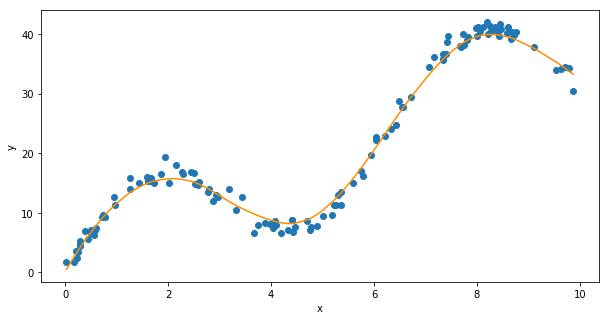

In [68]:
show_regression_line(X_test, y_test, y_pred.numpy())

## 总结

1. 高阶API
    > * 1.1 自动求导 
        >> * 要用tf的自动求导机制，需要将模型的参数设置为tf.Variable   
        >> * 然后打开一个tf.GradientTape对象，在它下面计算预测值和loss  
        >> * 调用tape的gradient方法求得导数  
        >> * tape.gradient接收target和sources两个参数，  
        >> * target就是loss损失值，sources是要求导的参数（如果是多个参数就用list打包，单个就直接填） 
        >> ```python
        self.coef_ = tf.Variable(
            tf.random.normal(shape=(self._X_train.shape[1], 1))) 
        with tf.GradientTape() as tape:  
            y_batch_pred = self._call(X_train_batch)  
            loss = self._loss_func(y_train_batch, y_batch_pred)  
        coef_grad, intercept_grad = tape.gradient(loss, [self.coef_, self.intercept_])  
        >>  ```
        >> * 默认tape只能使用一次，若要多次使用，with tf.GradientTape(persistent=True) as tape:
    > * 1.2 优化器optimiser  
        >> * 优化器类放在keras.optimizers下，常用SGD   
        >> * 实例化optimizer，参数learning_rate  
        >> * 可以调用optimizer.apply_gradients方法，利用导数更新参数  
        >> * apply_gradients方法接收一个list，list里都是tuple，tuple包含**导数**和**参数**  
        >> ```python
        self._optimizer = keras.optimizers.SGD(learning_rate=self.learning_rate)
        self._optimizer.apply_gradients([(coef_grad, self.coef_), (intercept_grad, self.intercept_)])
        >> ```  
     > * 1.3 损失计算方法  
        >> * 放在keras.losses下  
        >> * 可以直接调用mean_squared_error()方法，也可以实例化一个MeanSquaredError对象，也可以实例化一个mean_squared_error函数具柄  
        >> ```python  
        '''调用mean_squared_error方法'''
        loss = keras.losses.mean_squared_error(y_batch, y_pred)
        '''实例化MeanSquaredError对象'''
        mse = keras.losses.MeanSquaredError()
        loss = mse(y_batch, y_pred)
        '''实例化mean_squared_error函数具柄'''
        loss_func = keras.losses.mean_squared_error
        loss = loss_func(y_batch, y_pred)  
        >> ```
        >> * 累计损失平均值用metric，可以自动求平均loss  
        >> * 放在keras.metrics下，常用MeanSquaredError  
        >> * 重置平均值，调用metric的reset_states方法
        >> ```python  
        metric = keras.metrics.MeanSquaredError()
        mean_loss = metric(y_batch, y_pred) # 计算平均损失
        metric.reset_states() # 重置metric平均值，一般放在每个epoch的开始执行
        >> ```  
    > * 1.4 正则化
        >> * 放在keras.regularizers下  
        >> * l2正则器接收正则率参数l2, l1正则器接收正则率参数l1  
        >> * 将需要正则化的参数传给实例化的正则器，并加在loss中
        >> ```python
        self._regularizer = keras.regularizers.l2(l2=0.01)
        with tf.GradientTape() as tape:
            y_pred_batch = self._call(X_train_batch)
            loss = self._loss_func(y_train_batch, y_pred_batch) + self._regularizer(w)
        ...
        >> ```
    > * 1.5 dataset
        >> * tensorflow中使用tf.data.Dataset构建数据集  
        >> * tf.data.Dataset.from_tensor_slices(tensors)  
        >> numpy数据生成Dataset  
        >> * dataset.shuffle(buffer_size).batch(batch_size)   
        >> 调用shuffle等方法返回Dataset，可直接叠加方法（batch返回BatchDataset）  
        >> ```python
        def _batch_generator(self, X, y, shuffle=True):
            dataset = tf.data.Dataset.from_tensor_slices((X, y))
            if shuffle:
                dataset = dataset.shuffle(buffer_size=self._X_train.shape[0])
            dataset = dataset.batch(self.batch_size)
            return dataset
        >> ```
 
2. 基础API
    > * 2.1 tf.concat(values, axis)  
        >> 合并多个张量，values用list打包，每个张量的axis维度必须相同  
    > * 2.2 tf.random.set_seed(seed)  
        >> 设置random seed。和numpy不同，seed可以为负数
    > * 2.3 tf.random.normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None)   
        >> 高斯分布初始化参数  
    > * 2.4 tf.Variable().assign()   
        >> assign方法修改tf.Variable对象的值
    > * 2.5 tf.linalg.inv()    
        >> 求逆矩阵  
    > * 2.6 tf.matmul()
        >> 矩阵乘法，或者用@运算符
 
3. 坑
    > * 3.1 tensorflow不支持一维张量做矩阵乘法
        >> 所有要参与矩阵乘法的一维张量（self.coef_, y）都要初始化为shape为（\_, 1）的二维向量  
    > * 3.2 tensorflow不支持直接索引修改指定值  
        >> tf.Tensor常量不能修改
        >> 必须初始化为tf.Variable，调用assign方法修改
        >> ```python
        w = tf.Variable(tf.eye(self._X_train.shape[0]))
        w[i, i].assign(tf.exp(tf.reduce_sum(tf.square(diff)) / (-2 * self.k * 2)))
        >> ```
    > * 3.3 tf.Tensor不支持reshape方法，必须调用tf.reshape(tensor, shape)
    > * 3.4 tf.Tensorf不支持.T转置属性，必须调用tf.transpose(a)
    
4. SGD流程
    >```python
    """
    for epoch in arange(epoch):
        for batch in batch_ganerator(X_train, y_train):
            1. 计算预测值y_pred_batch
            2. 计算loss
            3. 通过loss获取导数
            4. 计算累计平均损失，并输出
            5. 更新参数
        for batch in batch_ganerator(X_valid, y_valid, shuffle=False):
            1. 计算valid累计平均损失
        1. 输出valid的累计平均损失  
        2. 保存最优参数  
        3. 判断early stopping  
    """
    > ```

## 作业

1. 手敲两遍，第一遍  
2. 搞懂每个API的输入和输出  
3. 尝试用TensorFlow实现多项式回归  

## 相关链接   

<a href="./02.1.LinearRegression.ipynb" style=""> 2.1 线性回归、岭回归、Lasso、SGD、局部加权线性回归原理</a>    
<a href="./02.2.LinearRegression-sklearn.ipynb" style=""> 2.2 sklearn中使用线性回归、岭回归、Lasso、SGD、多项式回归  </a>  
<a href="./02.3.LinearRegression-numpy.ipynb" style=""> 2.3 numpy实现线性回归、岭回归、SGD回归、LWLR</a>  

<a href="./02.5.LinearRegression-torch1.ipynb"> 2.5 PyTorch1实现线性回归、岭回归、SGD回归、LWLR </a>  

## 项目源码  

https://github.com/LossJ     
进入后点击Statistic-Machine-Learning